In [1]:
expID='vae_exp003'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize
from torchvision.utils import save_image
import os

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.cuda.empty_cache()

In [4]:
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np

# Define Constants

In [5]:
# Hyperparameters
image_size = 64
latent_dim = 200
hidden_dim = 256
batch_size = 64
epochs = 50
learning_rate = 1e-3
dataroot = 'data/'
ngpu = 1

# Create directory to save generated images
os.makedirs(f'vae_generated_images/{expID}', exist_ok=True)

# Data Preparation

In [6]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [7]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [8]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

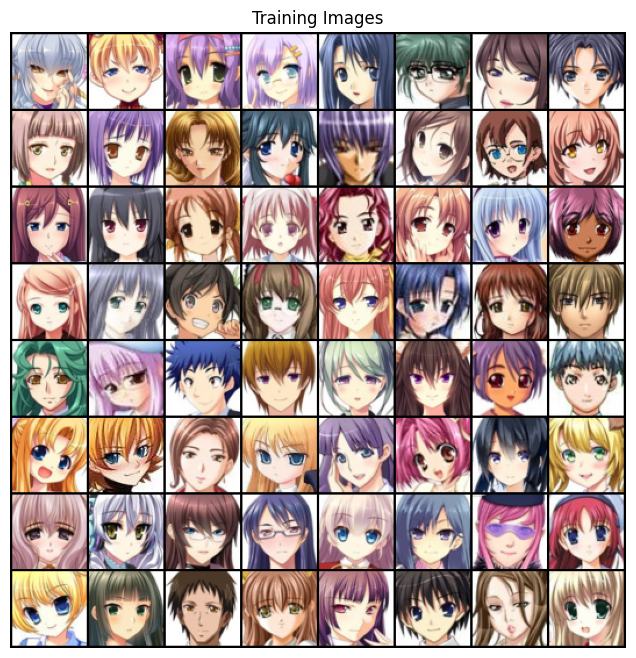

In [9]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Implementation

## Encoder Model

In [10]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # input shape: 3 x 64 x 64, output shape: 32 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # input shape: 32 x 32 x 32, output shape: 64 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # input shape: 64 x 16 x 16, output shape: 128 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),# input shape: 128 x 8 x 8, output shape: 256 x 4 x 4
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

## Decoder Model

In [11]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 256 * 4 * 4),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # input shape: 256 x 4 x 4, output shape: 128 x 8 x 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # input shape: 128 x 8 x 8, output shape: 64 x 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # input shape: 64 x 16 x 16, output shape: 32 x 32 x 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # input shape: 32 x 32 x 32, output shape: 3 x 64 x 64
            nn.Tanh()
        )
        
    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 256, 4, 4)
        x = self.deconv(x)
        return x

## VAE Model

In [12]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, logvar

In [13]:
# Loss function
# def loss_function(reconstructed_x, x, mu, logvar):
#     BCE = nn.functional.binary_cross_entropy(reconstructed_x, x, reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + KLD
def loss_function(reconstructed_x, x, mu, logvar):
    reconstructed_x = torch.sigmoid(reconstructed_x)  # Apply sigmoid activation
    BCE = nn.functional.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


# Create VAE instance and move it to the device
vae = VAE(latent_dim).to(device)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

## Training Loop

In [14]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [15]:
import datetime

In [16]:
start = datetime.datetime.now()

In [17]:
vae.train()

for epoch in range(epochs):
    total_loss = 0
    for batch_idx, data in enumerate(dataloader, 0):
        data = data[0].to(device)
        optimizer.zero_grad()
        reconstructed_data, mu, logvar = vae(data)
        loss = loss_function(reconstructed_data, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}')

    average_loss = total_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {average_loss:.4f}')

    # Generate sample images at the end of each epoch
    with torch.no_grad():
        fixed_noise = torch.randn(batch_size, latent_dim).to(device)
        generated_images = vae.decoder(fixed_noise).cpu()
        save_image(generated_images, f'vae_generated_images/{expID}/epoch_{epoch+1}.png', nrow=int(batch_size ** 0.5), normalize=True)

print("Training complete!")
end = datetime.datetime.now()

# Save the trained model
torch.save(vae.state_dict(), f'{expID}.pth')

Epoch [1/50], Batch [0/994], Loss: 541369.5000
Epoch [1/50], Batch [100/994], Loss: 371702.1562
Epoch [1/50], Batch [200/994], Loss: 342107.8125
Epoch [1/50], Batch [300/994], Loss: 289669.5625
Epoch [1/50], Batch [400/994], Loss: 299436.5938
Epoch [1/50], Batch [500/994], Loss: 332130.1562
Epoch [1/50], Batch [600/994], Loss: 301826.9062
Epoch [1/50], Batch [700/994], Loss: 302731.8438
Epoch [1/50], Batch [800/994], Loss: 290876.0938
Epoch [1/50], Batch [900/994], Loss: 311369.9375
Epoch [1/50], Average Loss: 4849.8284
Epoch [2/50], Batch [0/994], Loss: 275034.4062
Epoch [2/50], Batch [100/994], Loss: 285396.2500
Epoch [2/50], Batch [200/994], Loss: 269197.0938
Epoch [2/50], Batch [300/994], Loss: 293317.2188
Epoch [2/50], Batch [400/994], Loss: 295236.4062
Epoch [2/50], Batch [500/994], Loss: 268367.9062
Epoch [2/50], Batch [600/994], Loss: 255652.8281
Epoch [2/50], Batch [700/994], Loss: 278744.9688
Epoch [2/50], Batch [800/994], Loss: 286875.9375
Epoch [2/50], Batch [900/994], Loss

Epoch [16/50], Batch [500/994], Loss: 231778.5000
Epoch [16/50], Batch [600/994], Loss: 275212.0000
Epoch [16/50], Batch [700/994], Loss: 276164.0625
Epoch [16/50], Batch [800/994], Loss: 276734.7812
Epoch [16/50], Batch [900/994], Loss: 230123.1094
Epoch [16/50], Average Loss: 4169.8246
Epoch [17/50], Batch [0/994], Loss: 256326.9688
Epoch [17/50], Batch [100/994], Loss: 296692.5312
Epoch [17/50], Batch [200/994], Loss: 287424.5000
Epoch [17/50], Batch [300/994], Loss: 246916.1875
Epoch [17/50], Batch [400/994], Loss: 269651.3750
Epoch [17/50], Batch [500/994], Loss: 265145.0000
Epoch [17/50], Batch [600/994], Loss: 252659.7969
Epoch [17/50], Batch [700/994], Loss: 269146.8750
Epoch [17/50], Batch [800/994], Loss: 248979.9844
Epoch [17/50], Batch [900/994], Loss: 279774.1250
Epoch [17/50], Average Loss: 4167.1067
Epoch [18/50], Batch [0/994], Loss: 288354.5312
Epoch [18/50], Batch [100/994], Loss: 278874.0625
Epoch [18/50], Batch [200/994], Loss: 273866.9688
Epoch [18/50], Batch [300/

Epoch [31/50], Batch [800/994], Loss: 267112.0938
Epoch [31/50], Batch [900/994], Loss: 261440.3906
Epoch [31/50], Average Loss: 4142.1119
Epoch [32/50], Batch [0/994], Loss: 256229.0625
Epoch [32/50], Batch [100/994], Loss: 241203.2344
Epoch [32/50], Batch [200/994], Loss: 277665.1250
Epoch [32/50], Batch [300/994], Loss: 254585.5312
Epoch [32/50], Batch [400/994], Loss: 268680.0312
Epoch [32/50], Batch [500/994], Loss: 266377.2812
Epoch [32/50], Batch [600/994], Loss: 256424.9062
Epoch [32/50], Batch [700/994], Loss: 278308.5938
Epoch [32/50], Batch [800/994], Loss: 275515.0625
Epoch [32/50], Batch [900/994], Loss: 254079.8906
Epoch [32/50], Average Loss: 4140.9011
Epoch [33/50], Batch [0/994], Loss: 254841.1875
Epoch [33/50], Batch [100/994], Loss: 263045.2812
Epoch [33/50], Batch [200/994], Loss: 266643.7188
Epoch [33/50], Batch [300/994], Loss: 269090.4062
Epoch [33/50], Batch [400/994], Loss: 288706.0625
Epoch [33/50], Batch [500/994], Loss: 267459.7500
Epoch [33/50], Batch [600/

Epoch [47/50], Batch [0/994], Loss: 246425.4062
Epoch [47/50], Batch [100/994], Loss: 270674.5625
Epoch [47/50], Batch [200/994], Loss: 247388.3594
Epoch [47/50], Batch [300/994], Loss: 257353.8750
Epoch [47/50], Batch [400/994], Loss: 240083.2500
Epoch [47/50], Batch [500/994], Loss: 273946.9062
Epoch [47/50], Batch [600/994], Loss: 280480.7500
Epoch [47/50], Batch [700/994], Loss: 262453.3438
Epoch [47/50], Batch [800/994], Loss: 262469.5625
Epoch [47/50], Batch [900/994], Loss: 250323.6094
Epoch [47/50], Average Loss: 4129.0208
Epoch [48/50], Batch [0/994], Loss: 262787.3438
Epoch [48/50], Batch [100/994], Loss: 259527.2188
Epoch [48/50], Batch [200/994], Loss: 252477.0938
Epoch [48/50], Batch [300/994], Loss: 279805.4062
Epoch [48/50], Batch [400/994], Loss: 259601.8906
Epoch [48/50], Batch [500/994], Loss: 246363.9844
Epoch [48/50], Batch [600/994], Loss: 286170.0938
Epoch [48/50], Batch [700/994], Loss: 278301.0938
Epoch [48/50], Batch [800/994], Loss: 258443.5781
Epoch [48/50], 

In [18]:
print(start, end)

2023-05-20 14:25:05.637851 2023-05-20 14:43:16.564550


In [19]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
NVIDIA GeForce RTX 3060 Laptop GPU


In [20]:
loaded = VAE(latent_dim).to(device)
loaded.load_state_dict(torch.load(f'{expID}.pth'))

<All keys matched successfully>

In [21]:
loaded

VAE(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
    )
    (fc_mu): Linear(in_features=4096, out_features=200, bias=True)
    (fc_logvar): Linear(in_features=4096, out_features=200, bias=True)
  )
  (decoder): Decoder(
    (fc): Sequential(
      (0): Linear(in_features=200, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=4096, bias=True)
      (3): ReLU()
    )
    (deconv): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), p

In [22]:
with torch.no_grad():
    fixed_noise = torch.randn(1, latent_dim).to(device)
    img = loaded.decoder(fixed_noise).cpu()

(-0.5, 63.5, 63.5, -0.5)

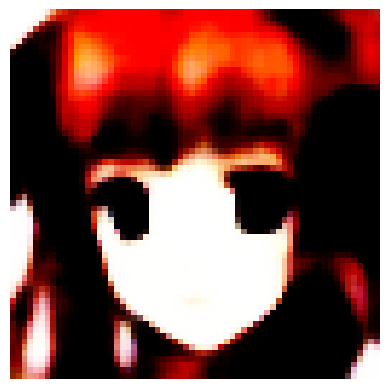

In [23]:
fake_img = vutils.make_grid(img, padding=2, normalize=True)
transposed = np.transpose(vutils.make_grid(fake_img, padding=5, normalize=True).cpu(),(1,2,0))
plt.imshow(transposed)
plt.axis('off')